In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [2]:
crypto_df = pd.read_csv('../data/cryptocurrency.csv')
stocks_df = pd.read_csv('../data/stocks.csv')

main_df = pd.concat([crypto_df,stocks_df])[['subreddit','selftext','title']]
main_df.reset_index(inplace=True)
main_df.drop(labels='index', inplace=True, axis=1)

In [3]:
main_df.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

### Data Cleaning

In [4]:
main_df.head()

,subreddit,selftext,title
0,CryptoCurrency,"I'm pretty new to crypto, just got in this yea...","Not Your Keys, Not Your Coin"
1,CryptoCurrency,Coinbase will not be launching its crypto lend...,The SEC bullied coinbase into dropping their 4...
2,CryptoCurrency,I strongly believe Ryan Reynolds and Rob McElh...,Wrexham Football Club as a DAO
3,CryptoCurrency,You will want to take your ALGOs off any excha...,"ALGO hodlers, don't forget governance starts O..."
4,CryptoCurrency,"If you're bringing up mobile phones, smart dev...",Blockchain's relevance- The link between milit...


In [5]:
main_df.tail()

,subreddit,selftext,title
2025,stocks,Hi all -- I'm hoping for help understanding wh...,Help requested: What is my 401(k) invested in?
2026,stocks,Obviously tobacco consumption has declined con...,Looking to get into weed/vape/tobacco companie...
2027,stocks,Hey guys. I have been using free tools until n...,What tools/services are worth paying for?
2028,stocks,What happens to stocks when the company goes b...,Can hedge funds or retail still own stock in a...
2029,stocks,I have 40k in my Charles Schwab account. My I...,Another annoying question about what I should ...


#### Initialise helper methods for data cleaning and confusion matrix plotting

In [6]:
def clean_data(data):
    url_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/\/=]*)(;\w+.?\w+)?'
    num_regex = r'\d+'
    word_regex = r"(\w+'*\w+)"#r'[A-Za-z]+'
    non_word_regex = r'(\&amp)[&;â€œ™,.]'
    x = re.sub(url_regex,'',data)
    x = re.sub(num_regex,'',x)
    word_tokenizer = RegexpTokenizer(word_regex)
    x = word_tokenizer.tokenize(x.lower())
    tokenizer = RegexpTokenizer(r'[?!\W+]')
    tmp_lst = list(filter(None,[re.sub(non_word_regex,'',i) for i in x]))
    lemmatizer = WordNetLemmatizer()
    lemma_tmp = [lemmatizer.lemmatize(tok) for tok in tmp_lst]
#     snow_stem = SnowballStemmer(language='english')
#     snow_tmp = [snow_stem.stem(tok) for tok in tmp_lst]
#     p_stemmer = PorterStemmer()
#     stem_tmp = [p_stemmer.stem(tok) for tok in tmp_lst]
    return ' '.join(lemma_tmp)

In [7]:
def metrics_and_plot_cm(classifier, X, y):
    preds = classifier.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)
    misclass = 1 - acc
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    results = {
        'Accuracy': acc,
        'Misclassification Rate': misclass,
        'Sensitivity': sens,
        'Specificity': spec,
        'Precision': prec
    }
    metrics = pd.DataFrame({
        'Metric': results.keys(),
        'Score': results.values()
        })
    plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d');
    return metrics

In [8]:
def compare_cvec_tvec(df):
    cvec = CountVectorizer(stop_words=list_of_stopwords)
    tvec = TfidfVectorizer(stop_words=list_of_stopwords)
    cvec_sc = cvec.fit_transform(df)
    cvec_df = pd.DataFrame(cvec_sc.todense(), columns=cvec.get_feature_names())
    tvec_sc = tvec.fit_transform(df)
    tvec_df = pd.DataFrame(tvec_sc.todense(), columns=tvec.get_feature_names())
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,15))
    cvec_df.sum().sort_values(ascending=False).head(30).plot(kind='barh', ax=ax[0])
    tvec_df.sum().sort_values(ascending=False).head(30).plot(kind='barh', ax=ax[1])
    ax[0].set_title('Count Vectorizer Word Count', fontweight='bold')
    ax[0].set_xlabel('Count')
    ax[0].set_ylabel('Word')
    ax[1].set_title('TFIDF Vectorizer Word Count', fontweight='bold')
    ax[1].set_xlabel('Count')
    ax[1].set_ylabel('Word')
    

#### Merge selftext and title as a combined feature to use as X

In [11]:
main_df['selftext_title'] = main_df['selftext'] + main_df['title']

In [12]:
main_df['selftext_title'] = main_df['selftext_title'].apply(clean_data)

In [13]:
main_df.head(5)

,subreddit,selftext,title,selftext_title
0,CryptoCurrency,"I'm pretty new to crypto, just got in this yea...","Not Your Keys, Not Your Coin",i'm pretty new to crypto just got in this year...
1,CryptoCurrency,Coinbase will not be launching its crypto lend...,The SEC bullied coinbase into dropping their 4...,coinbase will not be launching it crypto lendi...
2,CryptoCurrency,I strongly believe Ryan Reynolds and Rob McElh...,Wrexham Football Club as a DAO,strongly believe ryan reynolds and rob mcelhen...
3,CryptoCurrency,You will want to take your ALGOs off any excha...,"ALGO hodlers, don't forget governance starts O...",you will want to take your algos off any excha...
4,CryptoCurrency,"If you're bringing up mobile phones, smart dev...",Blockchain's relevance- The link between milit...,if you're bringing up mobile phone smart devic...


#### Map results of subreddit to 1 and 0

In [14]:
main_df['subreddit'] = main_df['subreddit'].map({'CryptoCurrency':1, 'stocks':0})
# main_df['subreddit'] = main_df['subreddit'].map({'CryptoCurrency':1, 'wallstreetbets':0})

In [15]:
X = main_df['selftext_title']
y = main_df['subreddit']

In [16]:
y.value_counts(normalize=True)

0    0.500985
1    0.499015
Name: subreddit, dtype: float64

#### Stopwords

Here, we use the base package of stopwords from the english language in the CountVectorizer library. This will allow us to exclude basic common terms which are uninformative in representing the context and content of the subreddit.

Additionally, to prevent overfitting the model with very easily classifiable words to the subreddit, we add and combine our own list of stopwords, which will be used across our models.

In [9]:
eng_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())
self_def_stopwords = ['cryptocurrency','crypto','stocks','stock','amp','share','like','just','make','shares','market','buy','people','time','don','money','price','companies','company','new','know','bitcoin','ethereum','ve','coin','btc','eth','long','day','good','year','think','going','gt','want', 'dip', 'news', 'years', 'sell','need', 'week','blockchain','coins','lot','said','term','way','use','trading','ha','wa','thi']
list_of_stopwords = eng_stopwords + self_def_stopwords

#### TODO: Create function to take in and compare words from Lemmatizer and Stemmer
Show 2 charts side by side for comparison. <br>
Explain choice of lemmatising vs stemmer

#### Comparison of top 30 word counts between CountVectorizer and TFIDFVectorizer

From the charts below in comparison with our stopwords, we can see that CountVectorizer, which tends to only count the highest frequency of words, picks out words that are commonly used within our subreddits.

TFIDFVectorizer on the other hand, is able to pick up much more relatable words to the topic instead.

We will also see the comparison of CountVectorizer and TFIDFVectorizer later in our models, and we will notice that models using TFIDFVectorizer tend to provide better results

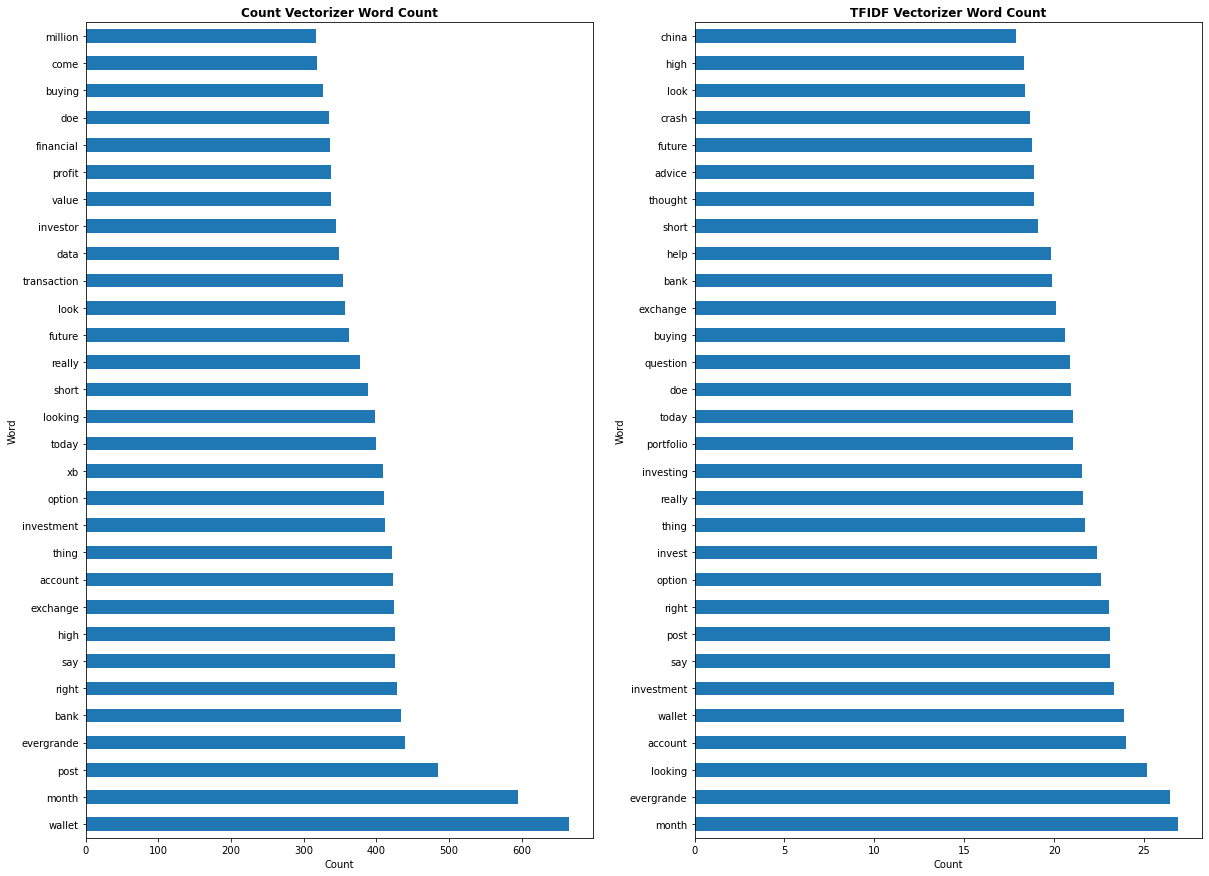

In [17]:
compare_cvec_tvec(main_df['selftext_title'])

### Train Test and Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [ ]:
cvec = CountVectorizer(stop_words=list_of_stopwords, ngram_range=(1,2))
cvec.fit(X_train)

In [ ]:
X_train_sc = cvec.transform(X_train)

In [ ]:
X_train_sc

In [ ]:
X_train_df = pd.DataFrame(X_train_sc.todense(),
                         columns=cvec.get_feature_names())

In [ ]:
X_train_df.sum().sort_values(ascending=False).head(40).index

In [ ]:
plt.figure(figsize=(15,15))
X_train_df.sum().sort_values(ascending=False).head(40).plot(kind='barh')

### Logistic Regression

#### CountVectorizer with Logistic Regression

In [ ]:
pipe_cvec_logreg = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('logreg',LogisticRegression()),
])

In [ ]:
# pipe_logreg_params = {
#     'cvec__max_features': [None,2000,3000,4000,5000],
#     'cvec__min_df': [2,3],
#     'cvec__max_df': [.85,.9,.95],
#     'cvec__ngram_range': [(1,1),(1,2),(1,3)],
# }


pipe_cvec_logreg_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.85],
    'cvec__ngram_range': [(1,2)],
}

In [ ]:
gs_cvec_logreg = GridSearchCV(pipe_cvec_logreg, param_grid=pipe_cvec_logreg_params, cv=5)

In [ ]:
gs_cvec_logreg.fit(X_train,y_train)

In [ ]:
gs_cvec_logreg.best_score_

In [ ]:
gs_cvec_logreg.best_params_

In [ ]:
gs_cvec_logreg.score(X_train,y_train)

In [ ]:
gs_cvec_logreg.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_cvec_logreg,X_test, y_test)

#### TFIDF Vectorizer with Logistic Regression

In [ ]:
pipe_tvec_logreg = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('logreg',LogisticRegression()),
])

In [ ]:
# pipe_logreg_tvec_params = {
#     'tvec__max_features': [None,2000,3000,4000,5000],
#     'tvec__min_df': [2,3],
#     'tvec__max_df': [.85,.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
# }

pipe_tvec_logreg_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.85],
    'tvec__ngram_range': [(1,3)],
}

In [ ]:
gs_tvec_logreg = GridSearchCV(pipe_tvec_logreg, param_grid=pipe_tvec_logreg_params, cv=5)

In [ ]:
%%time
gs_tvec_logreg.fit(X_train,y_train)

In [ ]:
gs_tvec_logreg.best_score_

In [ ]:
gs_tvec_logreg.best_params_

In [ ]:
gs_tvec_logreg.score(X_train,y_train)

In [ ]:
gs_tvec_logreg.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_tvec_logreg,X_test, y_test)

#### CountVectorizer with k-NN Classifier

In [ ]:
pipe_cvec_knn = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('knn',KNeighborsClassifier()),
])

In [ ]:
# pipe_cvec_knn_params = {
#     'cvec__max_features': [None,2000,3000,4000,5000],
#     'cvec__min_df': [2,3],
#     'cvec__max_df': [.85],
#     'cvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'knn__n_neighbors': [5,6,7,8,9,10],

# }

pipe_cvec_knn_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.85],
    'cvec__ngram_range': [(1,1)],
    'knn__n_neighbors': [13],

}



In [ ]:
gs_cvec_knn = GridSearchCV(pipe_cvec_knn, param_grid=pipe_cvec_knn_params, cv=5, verbose=1)

In [ ]:
%%time
gs_cvec_knn.fit(X_train, y_train)

In [ ]:
gs_cvec_knn.best_params_

In [ ]:
gs_cvec_knn.score(X_train, y_train)

In [ ]:
gs_cvec_knn.score(X_test,y_test)

In [ ]:
metrics_and_plot_cm(gs_cvec_knn,X_test, y_test)

#### TFIDF Vectorizer with k-NN Classifier

In [ ]:
pipe_tvec_knn = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('knn',KNeighborsClassifier()),
])

In [ ]:
pipe_tvec_knn_params = {
    'tvec__max_features': [None],
     'tvec__min_df': [.01],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1)],
    'knn__n_neighbors': [13],

}

In [ ]:
gs_tvec_knn = GridSearchCV(pipe_tvec_knn, param_grid=pipe_tvec_knn_params, cv=5, verbose=1)

In [ ]:
%%time
gs_tvec_knn.fit(X_train, y_train)

In [ ]:
gs_tvec_knn.best_params_

In [ ]:
gs_tvec_knn.best_score_

In [ ]:
gs_tvec_knn.score(X_train, y_train)

In [ ]:
gs_tvec_knn.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_tvec_knn,X_test, y_test)

#### Using CountVectorizer with Naive Bayes

In [ ]:
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('nb', MultinomialNB())
])

In [ ]:
pipe_cvec_nb_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,2)],
    'nb__alpha':[0.25]
}

In [ ]:
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, param_grid=pipe_cvec_nb_params, cv=5, verbose=1)

In [ ]:
%%time
gs_cvec_nb.fit(X_train, y_train)

In [ ]:
print(gs_cvec_nb.best_score_)

In [ ]:
gs_cvec_nb.best_params_

In [ ]:
gs_cvec_nb.score(X_train, y_train)

In [ ]:
gs_cvec_nb.score(X_test,y_test)

In [ ]:
metrics_and_plot_cm(gs_cvec_nb,X_test, y_test)

#### Using TFIDF Vectorizer with Naive Bayes Classifier

In [ ]:
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('nb', MultinomialNB())
])

In [ ]:
# pipe_tvec_nb_params = {
#     'tvec__max_features': [None,2000,3000,4000],
#     'tvec__min_df': [.2],
#     'tvec__max_df': [.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'nb__alpha':[0.1,1,10]
# }

pipe_tvec_nb_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1)],
    'nb__alpha':[0.1]
}


In [ ]:
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, param_grid=pipe_tvec_nb_params, cv=5, verbose=1)

In [ ]:
%%time
gs_tvec_nb.fit(X_train, y_train)

In [ ]:
gs_tvec_nb.score(X_train,y_train)

In [ ]:
gs_tvec_nb.score(X_test, y_test)

In [ ]:
gs_tvec_nb.best_score_

In [ ]:
metrics_and_plot_cm(gs_tvec_nb,X_test, y_test)

#### Using CountVectorizer with DecisionTreeClassifier

In [ ]:
pipe_cvec_tree = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('tree', DecisionTreeClassifier())
])

In [ ]:
pipe_cvec_tree_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,1)],
    'tree__max_depth': [None],
    'tree__min_samples_split': [30],
    'tree__min_samples_leaf': [5],
    'tree__ccp_alpha': [0.001]
}

In [ ]:
gs_cvec_tree = GridSearchCV(estimator=pipe_cvec_tree, 
                            param_grid=pipe_cvec_tree_params,
                            cv=5,
                            verbose=1)

In [ ]:
%%time
gs_cvec_tree.fit(X_train, y_train)

In [ ]:
gs_cvec_tree.best_params_

In [ ]:
gs_cvec_tree.best_score_

In [ ]:
gs_cvec_tree.score(X_train, y_train)

In [ ]:
gs_cvec_tree.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_cvec_tree,X_test, y_test)

#### Using TFIDFVectorizer with DecisionTreeClassifier

In [ ]:
pipe_tvec_tree = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('tree', DecisionTreeClassifier())
])

In [ ]:
# pipe_tree_params = {
#     'tvec__max_features': [None],
#     'tvec__min_df': [.2,.3],
#     'tvec__max_df': [.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2)],
#     'tree__max_depth': [None],
#     'tree__min_samples_split': [5,10,15,20],
#     'tree__min_samples_leaf': [2,3,4,5,6],
#     'tree__ccp_alpha': [0,0.001,0.01,0.1,1,10]
# }

pipe_tvec_tree_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1)],
    'tree__max_depth': [None],
    'tree__min_samples_split': [30],
    'tree__min_samples_leaf': [2],
    'tree__ccp_alpha': [0.001]
}

In [ ]:
gs_tvec_tree = GridSearchCV(estimator = pipe_tvec_tree,
                      param_grid=pipe_tvec_tree_params,
                      cv=5,
                      verbose=1
                     )

In [ ]:
%%time
gs_tvec_tree.fit(X_train, y_train)

In [ ]:
gs_tvec_tree.best_params_

In [ ]:
gs_tvec_tree.best_score_

In [ ]:
gs_tvec_tree.score(X_train, y_train)

In [ ]:
gs_tvec_tree.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_tvec_tree,X_test, y_test)

#### Using CountVectorizer with Bagging

In [ ]:
pipe_cvec_bag = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('bag', BaggingClassifier(bootstrap=True))
])

In [ ]:
# Best params found
pipe_cvec_bag_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,2)],
    'bag__n_estimators': [40],
}

In [ ]:
gs_cvec_bag = GridSearchCV(estimator = pipe_cvec_bag,
                      param_grid=pipe_cvec_bag_params,
                      cv=5,
                      verbose=1
                     )

In [ ]:
%%time
gs_cvec_bag.fit(X_train, y_train)

In [ ]:
gs_cvec_bag.best_params_

In [ ]:
gs_cvec_bag.best_score_

In [ ]:
gs_cvec_bag.score(X_train, y_train)

In [ ]:
gs_cvec_bag.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_cvec_bag,X_test, y_test)

#### Using TFIDFVectorizer with Bagging

In [ ]:
pipe_tvec_bag = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('bag', BaggingClassifier(bootstrap=True))
])

In [ ]:
# pipe_bag_params = {
#     'tvec__max_features': [None,2000,3000,4000,5000],
#     'tvec__min_df': [.2,.3],
#     'tvec__max_df': [.85,.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'bag__n_estimators': [10,20,30],
# }

# Best params found
pipe_tvec_bag_params = {
    'tvec__max_features': [None],
     'tvec__min_df': [.01],
     'tvec__max_df': [.95],
    'tvec__ngram_range': [(1,1)],
    'bag__n_estimators': [40],
}

In [ ]:
gs_tvec_bag = GridSearchCV(estimator = pipe_tvec_bag,
                      param_grid=pipe_tvec_bag_params,
                      cv=5,
#                       verbose=1
                     )

In [ ]:
%%time
gs_tvec_bag.fit(X_train, y_train)

In [ ]:
gs_tvec_bag.best_params_

In [ ]:
gs_tvec_bag.best_estimator_

In [ ]:
gs_tvec_bag.best_score_

In [ ]:
gs_tvec_bag.score(X_train, y_train)

In [ ]:
gs_tvec_bag.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_tvec_bag,X_test, y_test)

#### CountVectorizer with RandomForest Classifier

In [ ]:
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('rf', RandomForestClassifier()),
])

In [ ]:
pipe_cvec_rf_params = {
    'cvec__max_features': [3000],
    'cvec__min_df': [.01],
    'cvec__max_df': [.95],
    'cvec__ngram_range': [(1,1)],
    'rf__n_estimators':[200],
    'rf__max_depth':  [None],
}

In [ ]:
gs_cvec_rf = GridSearchCV(estimator=pipe_cvec_rf,
                     param_grid=pipe_cvec_rf_params,
                     cv=5,
#                      verbose=1
                    )

In [ ]:
%%time
gs_cvec_rf.fit(X_train, y_train)

In [ ]:
gs_cvec_rf.best_params_

In [ ]:
gs_cvec_rf.best_score_

In [ ]:
gs_cvec_rf.score(X_train, y_train)

In [ ]:
gs_cvec_rf.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_cvec_rf,X_test, y_test)

#### Using TFIDFVectorizer with Random Forest Classifier

In [ ]:
pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('rf', RandomForestClassifier()),
])

In [ ]:
# pipe_rf_params = {
#     'tvec__max_features': [None,2000,3000],
#     'tvec__min_df': [.2,.3],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'rf__n_estimators':[100,150,200],
#     'rf__max_depth': [None, 1, 2, 3],
# }

# Best params for Random Forest
pipe_tvec_rf_params = {
    'tvec__max_features': [4000],
    'tvec__min_df': [.01],
#     'tvec__max_df': [.95],
    'tvec__ngram_range': [(1,2)],
    'rf__n_estimators':[150],
    'rf__max_depth':  [None],
}

In [ ]:
gs_tvec_rf = GridSearchCV(estimator=pipe_tvec_rf,
                     param_grid=pipe_tvec_rf_params,
                     cv=5,
#                      verbose=1
                    )

In [ ]:
%%time
gs_tvec_rf.fit(X_train, y_train)

In [ ]:
gs_tvec_rf.best_params_

In [ ]:
gs_tvec_rf.best_score_

In [ ]:
gs_tvec_rf.score(X_train, y_train)

In [ ]:
gs_tvec_rf.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_tvec_rf,X_test, y_test)

#### CountVectorizer with ExtraTreesClassifier

In [ ]:
pipe_cvec_et = Pipeline([
    ('cvec', CountVectorizer()),
    ('et', ExtraTreesClassifier()),
])

In [ ]:
pipe_cvec_et_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.95],
    'cvec__ngram_range': [(1,2)],
    'et__n_estimators':[500],
    'et__max_depth':  [None],
}

In [ ]:
gs_cvec_et = GridSearchCV(pipe_cvec_et, param_grid=pipe_cvec_et_params,cv=5,verbose=1)

In [ ]:
%%time
gs_cvec_et.fit(X_train, y_train)

In [ ]:
gs_cvec_et.best_params_

In [ ]:
gs_cvec_et.best_score_

In [ ]:
gs_cvec_et.score(X_train, y_train)

In [ ]:
gs_cvec_et.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_cvec_et,X_test, y_test)

#### TFIDFVectorizer with ExtraTreesClassifier

In [ ]:
pipe_tvec_et = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier()),
])

In [ ]:
pipe_tvec_et_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.95],
    'tvec__ngram_range': [(1,1)],
    'et__n_estimators':[600],
    'et__max_depth':  [None],
}

In [ ]:
gs_tvec_et = GridSearchCV(pipe_tvec_et, param_grid=pipe_tvec_et_params,cv=5,verbose=1)

In [ ]:
%%time
gs_tvec_et.fit(X_train, y_train)

In [ ]:
gs_tvec_et.best_params_

In [ ]:
gs_tvec_et.best_score_

In [ ]:
gs_tvec_et.score(X_train, y_train)

In [ ]:
gs_tvec_et.score(X_test, y_test)

In [ ]:
metrics_and_plot_cm(gs_tvec_et,X_test, y_test)